# ChatGPT version 23 July 2023

## ABC-SMC for Bacterial Recontamination Model

We will use Approximate Bayesian Computation via Sequential Monte Carlo (ABC-SMC) to fit a model of bacterial recontamination. The model describes the change in bacterial concentration over time, taking into account the natural growth of the bacteria, the carrying capacity of the skin, the effectiveness of a sanitizer, and recontamination.

In [6]:
import numpy as np
from scipy.integrate import odeint
import pyabc as pyabc
from pyabc import (ABCSMC,
                   RV, Distribution,
                   MedianEpsilon,
                   LocalTransition)
from pyabc.visualization import plot_kde_2d, plot_data_callback
from pyabc.visualization import plot_kde_1d
import matplotlib.pyplot as plt
import pandas as pd


In [238]:
df = pd.read_csv('../data/gerba.data.20200302.csv')
#drop Unnamed: 0 column
df = df.drop(['Unnamed: 0'], axis=1)
# calcualte the median conc at each time for each group and each treatment
df_median = df.groupby(['group', 'time','treatment']).median().reset_index()

group1_treated = df_median[(df_median["group"] == "Group 1") & (df_median["treatment"] == "Treated")]["conc"].values
group1_untreated = df_median[(df_median["group"] == "Group 1") & (df_median["treatment"] == "Untreated")]["conc"].values
group1_ratio = group1_treated / group1_untreated

group2_treated = df_median[(df_median["group"] == "Group 2") & (df_median["treatment"] == "Treated")]["conc"].values
group2_untreated = df_median[(df_median["group"] == "Group 2") & (df_median["treatment"] == "Untreated")]["conc"].values
group2_ratio = group2_treated / group2_untreated

observed_data_group1 = {"B_group1": group1_ratio}
observed_data_group2 = {"B_group2": group2_ratio}


In [239]:
df

,conc,time,id,treatment,group
0,12800,0,1,Untreated,Group 1
1,22800,0,2,Untreated,Group 1
2,16000,0,3,Untreated,Group 1
3,19000,0,4,Untreated,Group 1
4,32200,0,5,Untreated,Group 1
...,...,...,...,...,...
85,3360,24,6,Treated,Group 2
86,2120,24,7,Treated,Group 2
87,1460,24,8,Treated,Group 2
88,2960,24,9,Treated,Group 2


In [74]:
group2_ratio

array([0.00395833, 0.00695652, 0.00525253, 0.00910714, 0.00747475])

## 1.1 Plot the Ratio

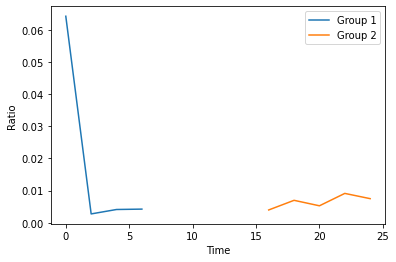

In [4]:
# plot the group1_ratio and group2_ratio on the same time axis  
plt.plot(np.array([0,2,4,6]), group1_ratio, label="Group 1")
plt.plot(np.array([16,18,20,22,24]), group2_ratio, label="Group 2")#
plt.legend()
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.show()


## Define the model

The model is defined as an ordinary differential equation (ODE). The bacteria_model function calculates the rate of change of the bacterial concentration at a given time.

In [58]:
def bacteria_model_treated(B, t, r, K, a, b):
    dBdt = r * B * (1 - B / K) - a * np.exp(-b * t) * B # Logistic growth with decay
    return dBdt

def bacteria_model_untreated(B, t, r, K):
    dBdt = r * B * (1 - B / K)  # Logistic growth with decay
    return dBdt


## Define the simulation function

The simulate function simulates from the model given a set of parameters. It uses the odeint function from scipy.integrate to solve the ODE.

In [215]:
'''
def simulate(parameters):
    B0_untreated = 100  # Initial bacteria population for untreated model
    B0_treated = parameters["B0_treated"]  # Initial bacteria population for treated model
    
    t = np.array([0,  2,  4,  6, 16, 18, 20, 22, 24])  # Actual time points
    
    # Define parameters for bacteria_model_treated and bacteria_model_untreated
    args_treated = (parameters["r"], parameters["K"], parameters["a"], parameters["b"])
    args_untreated = (parameters["r"], parameters["K"])

    # Simulate untreated and treated data
    B_untreated = odeint(bacteria_model_untreated, B0_untreated, t, args=args_untreated)
    B_treated = odeint(bacteria_model_treated, B0_treated, t, args=args_treated)

    # Calculate the ratio
    B_ratio = B_treated / B_untreated

    # Separate the ratio data for Group 1 and Group 2
    B_ratio_group1 = B_ratio[:4]
    B_ratio_group2 = B_ratio[4:]

    return {"B_group1": B_ratio_group1, "B_group2": B_ratio_group2}
'''
def simulate(parameters):
    B0_untreated = 100  # Initial bacteria population for untreated model
    B0_treated_group1 = parameters["B0_treated_group1"] 
    B0_treated_group2 = parameters["B0_treated_group2"]
    
    t = np.array([0,  2,  4,  6, 16, 18, 20, 22, 24])  # Actual time points
    
    # Define parameters for bacteria_model_treated and bacteria_model_untreated
    args_treated_group1 = (parameters["r"], parameters["K"], parameters["a_group1"], parameters["b_group1"])
    args_treated_group2 = (parameters["r"], parameters["K"], parameters["a_group2"], parameters["b_group2"])
    args_untreated = (parameters["r"], parameters["K"])

    # Simulate untreated and treated data
    B_untreated = odeint(bacteria_model_untreated, B0_untreated, t, args=args_untreated)
    B_treated_group1 = odeint(bacteria_model_treated, B0_treated_group1, t, args=args_treated_group1)
    B_treated_group2 = odeint(bacteria_model_treated, B0_treated_group2, t, args=args_treated_group2)

    # Calculate the ratio
    B_ratio_group1 = B_treated_group1 / B_untreated
    B_ratio_group2 = B_treated_group2 / B_untreated

    # Separate the ratio data for Group 1 and Group 2
    B_ratio_group1 = B_ratio_group1[:4]
    B_ratio_group2 = B_ratio_group2[4:]

    return {"B_group1": B_ratio_group1.tolist(), "B_group2": B_ratio_group2.tolist()}



## Test Plot

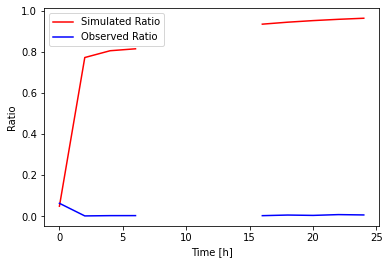

In [225]:
# using a set of test parameters to simulate the data and plot aganist the ratio data. Keep simulated lines red and observed lines blue
test_parameters = {"B0_treated_group1":5,"B0_treated_group2":1.2,
"r": 0.05, "K": 0.1, "a_group1": 0.1, "b_group1": 0.2,
 "a_group2": 0.01, "b_group2": 2}
simulated_data = simulate(test_parameters)

plt.plot(np.array([0,2,4,6]), simulated_data["B_group1"], label="Simulated Ratio", color="red")
plt.plot(np.array([16,18,20,22,24]), simulated_data["B_group2"], color="red")
plt.plot(np.array([0,2,4,6]), observed_data_group1["B_group1"], label="Observed Ratio", color="blue")
plt.plot(np.array([16,18,20,22,24]), observed_data_group2["B_group2"], color="blue")
plt.legend()
plt.xlabel("Time [h]")
plt.ylabel("Ratio")
plt.show()





## Define the prior distribution

The prior distributions for the parameters are defined as uniform distributions. These should be adjusted to reflect your own prior knowledge about the parameters.

In [193]:


prior = pyabc.Distribution(
    B0_treated_group1=pyabc.RV("uniform", 0, 100), 
    B0_treated_group2=pyabc.RV("uniform", 0, 100), 
    r=pyabc.RV("uniform", 0, 0.1), 
    K=pyabc.RV("uniform", 0, 1000), 
    a_group1=RV("uniform", 0, 1),
    b_group1=RV("uniform", 0, 0.1),
    a_group2=RV("uniform", 0, 1),
    b_group2=RV("uniform", 0, 0.1),
)


## Define the distance function

The distance function calculates the L1 norm (absolute difference) between the observed and simulated data. This function is used by the ABC-SMC algorithm to compare the simulated data to the observed data.

In [206]:
'''
class CustomDistance(pyabc.Distance):
    def __call__(self, x, x_0):
        return abs(x["B_group1"] - x_0["B_group1"]) + abs(x["B_group2"] - x_0["B_group2"])

distance = CustomDistance()
'''

def distance(observed_data, simulated_data):
    distance_group1 = np.sum((observed_data['B_group1'] - simulated_data['B_group1'])**2)
    distance_group2 = np.sum((observed_data['B_group2'] - simulated_data['B_group2'])**2)
    return distance_group1 + distance_group2

def weighted_distance(observed_data, simulated_data):
    # Define weights for group 1 and group 2
    weights_group1 = np.array([4, 3, 2, 1])
    weights_group2 = np.array([1, 1, 1, 1, 1])

    distance_group1 = np.sum(weights_group1 * (observed_data['B_group1'] - simulated_data['B_group1'])**2)
    distance_group2 = np.sum(weights_group2 * (observed_data['B_group2'] - simulated_data['B_group2'])**2)
    return distance_group1 + distance_group2



## Run the ABC-SMC algorithm

The ABC-SMC algorithm is initialized with the simulation function, the prior distributions, the distance function, and some settings. The algorithm is then run separately for each group of data.

In [188]:
observed_data_group1['B_group1']

array([0.06421053, 0.00272727, 0.00410156, 0.00422078])

In [233]:
#Noisey model
sigma=0.02
acceptor = pyabc.StochasticAcceptor()
kernel = pyabc.IndependentNormalKernel(var=sigma**2)
eps = pyabc.Temperature()

# ABCSMC setup
#abc = ABCSMC(models=simulate, parameter_priors=prior,distance_function=distance, kernel, eps=eps, acceptor=acceptor, population_size=1000)
abc = ABCSMC(models=simulate,
               parameter_priors=prior,
               distance_function=weighted_distance,
               population_size=1000,
               acceptor=pyabc.UniformAcceptor(use_complete_history=True))
# Combined observed data for both groups
observed_data_combined = {'B_group1': observed_data_group1['B_group1'], 'B_group2': observed_data_group2['B_group2']}

# Running ABCSMC
abc.new("sqlite:///abc_combined.db", observed_data_combined)
history = abc.run(max_nr_populations=5, minimum_epsilon=0.0001)




ABC.Sampler INFO: Parallelize sampling on 8 processes.
ABC.History INFO: Start <ABCSMC id=16, start_time=2023-07-24 16:18:11>
ABC INFO: Calibration sample t = -1.
ABC INFO: t: 0, eps: 3.41657344e+00.
ABC INFO: Accepted: 1000 / 1990 = 5.0251e-01, ESS: 1.0000e+03.
ABC INFO: t: 1, eps: 7.82709418e-01.
ABC INFO: Accepted: 1000 / 2131 = 4.6926e-01, ESS: 3.9465e+02.
ABC INFO: t: 2, eps: 2.03668687e-01.
ABC INFO: Accepted: 1000 / 2194 = 4.5579e-01, ESS: 4.6809e+02.
ABC INFO: t: 3, eps: 7.08986544e-02.
ABC INFO: Accepted: 1000 / 2275 = 4.3956e-01, ESS: 2.9100e+02.
ABC INFO: t: 4, eps: 5.58519563e-02.
ABC INFO: Accepted: 1000 / 1997 = 5.0075e-01, ESS: 4.1121e+02.
ABC INFO: Stop: Maximum number of generations.
ABC.History INFO: Done <ABCSMC id=16, duration=0:01:39.187068, end_time=2023-07-24 16:19:50>


## Plot the prediction against the actual data


In [235]:
simulated_data = simulate(best_parameters)

{'B0_treated_group1': 2.2067024833258144, 'B0_treated_group2': 3.2590368057906467, 'K': 610.7470144704516, 'a_group1': 0.3543168126519398, 'a_group2': 0.09430900769401918, 'b_group1': 0.06655342017187554, 'b_group2': 0.042436603516979726, 'r': 0.01066606387441424}


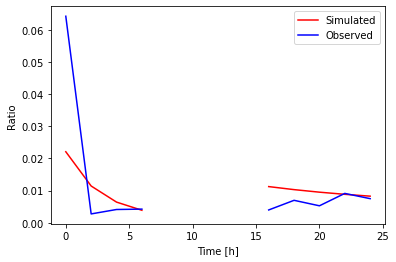

In [236]:
# Get the id of the final population
last_population_id = history.max_t

# Get the DataFrame of parameter values and weights for the final population
pred_df, weights = history.get_distribution(m=0, t=last_population_id)

best_parameters = pred_df.iloc[weights.argmax()].to_dict()
print(best_parameters)

# plot the simulated data and observed data on the same time axis using best_parameters
simulated_data = simulate(best_parameters)

plt.plot(np.array([0,2,4,6]), simulated_data["B_group1"], label="Simulated", color="red")
plt.plot(np.array([16,18,20,22,24]), simulated_data["B_group2"], color="red")
plt.plot(np.array([0,2,4,6]), observed_data_group1["B_group1"], color="blue")
plt.plot(np.array([16,18,20,22,24]), observed_data_group2["B_group2"], label="Observed", color="blue")
plt.legend()
plt.xlabel("Time [h]")
plt.ylabel("Ratio")
plt.show()



In [209]:
simulated_data

{'B_group1': [[0.0269633437570105],
  [0.027176320781166396],
  [0.027472130604905453],
  [0.027852528158389556]],
 'B_group2': [[0.007503186381624936],
  [0.007212166130164747],
  [0.00698615498077212],
  [0.006817817960193006],
  [0.006701530852070214]]}

In [149]:
observed_data_list

[{'B_group1': array([0.06421053, 0.00272727, 0.00410156, 0.00422078])},
 {'B_group2': array([0.00395833, 0.00695652, 0.00525253, 0.00910714, 0.00747475])}]

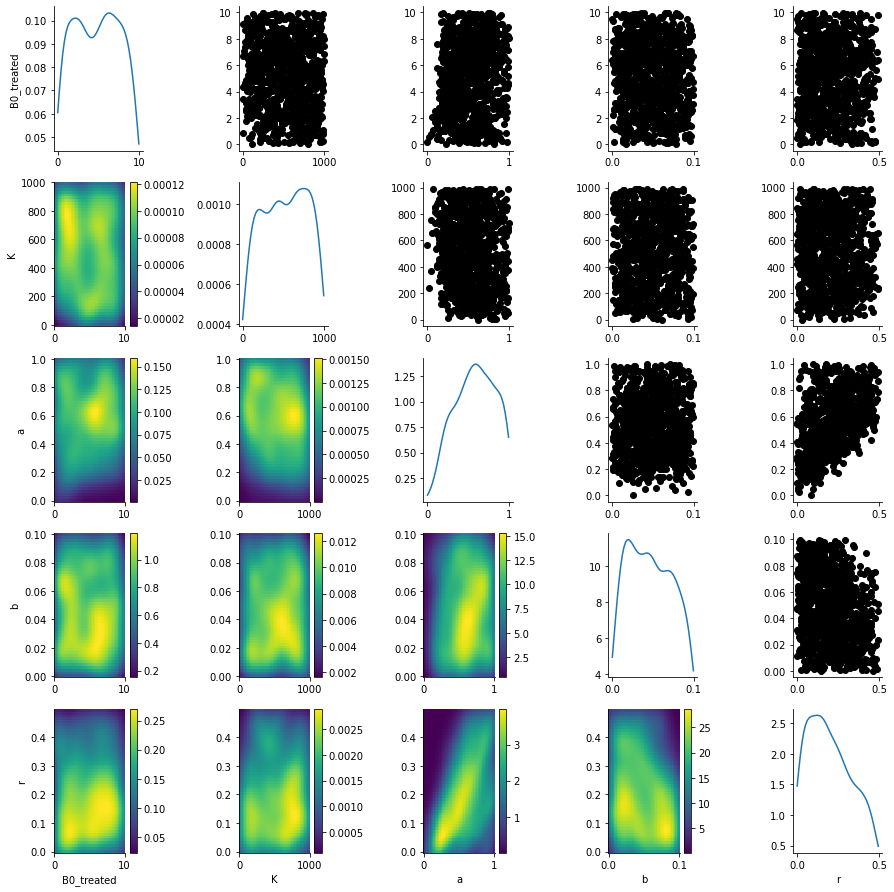

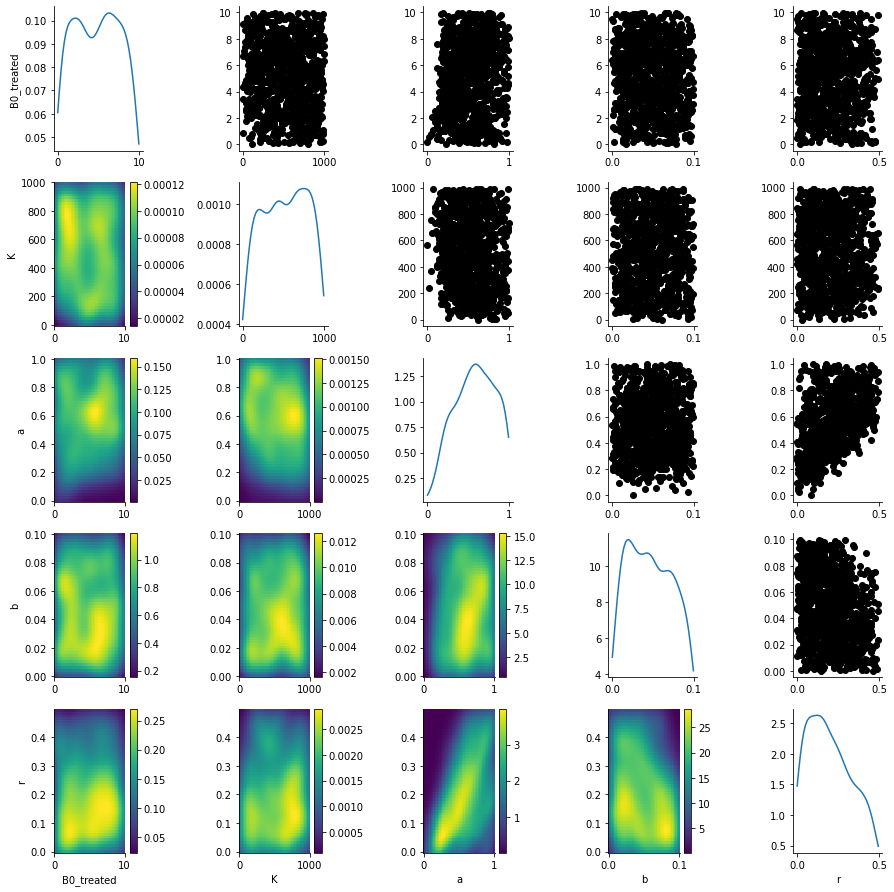

In [212]:
from pyabc.visualization import plot_kde_2d, plot_kde_1d, plot_kde_matrix

# For each group
for i, observed_data_key in enumerate(observed_data_keys):
    # Load the history
    db_path = "sqlite:///abc_{}.db".format(observed_data_key)
    history = pyabc.History(db_path)
        # Or plot the whole matrix at once
    plot_kde_matrix(df, w)
    plt.show()
